<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/main/fashion_MNIST_GANMAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
Using device: cpu


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.82MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.3MB/s]


Epoch 1/20, Meta Loss: -6.5477
Epoch 2/20, Meta Loss: -7.0439
Epoch 3/20, Meta Loss: -6.7781
Epoch 4/20, Meta Loss: -7.1383
Epoch 5/20, Meta Loss: -7.1343
Epoch 6/20, Meta Loss: -6.8357
Epoch 7/20, Meta Loss: -7.3080
Epoch 8/20, Meta Loss: -6.6529
Epoch 9/20, Meta Loss: -6.7125
Epoch 10/20, Meta Loss: -6.0900
Epoch 11/20, Meta Loss: -6.7247
Epoch 12/20, Meta Loss: -6.6149
Epoch 13/20, Meta Loss: -6.6499
Epoch 14/20, Meta Loss: -6.5971
Epoch 15/20, Meta Loss: -6.3585
Epoch 16/20, Meta Loss: -6.1628
Epoch 17/20, Meta Loss: -6.1363
Epoch 18/20, Meta Loss: -6.7054
Epoch 19/20, Meta Loss: -6.8181
Epoch 20/20, Meta Loss: -6.6981
Fine-tune step 10, D Loss: -18.0721, G Loss: -163.5539


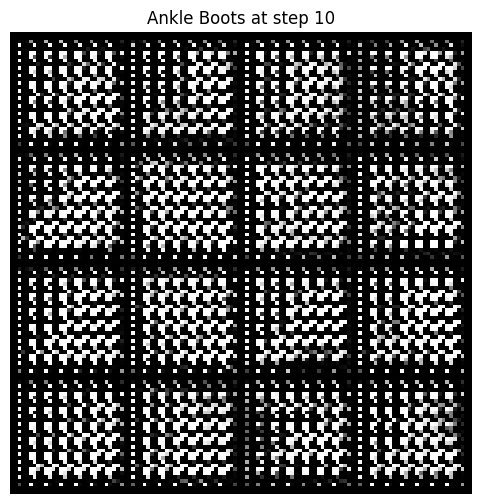

Fine-tune step 20, D Loss: 12.5192, G Loss: -475.6047


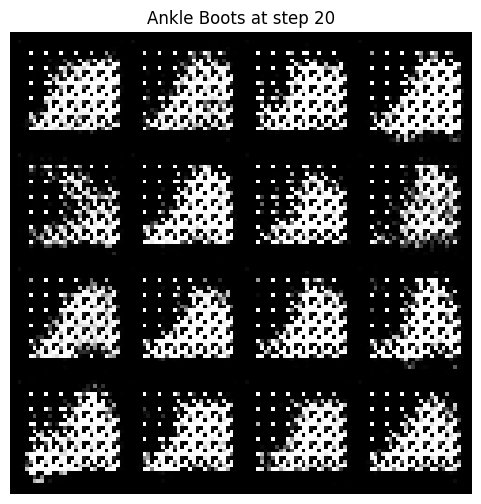

Fine-tune step 30, D Loss: 27.6843, G Loss: -830.9955


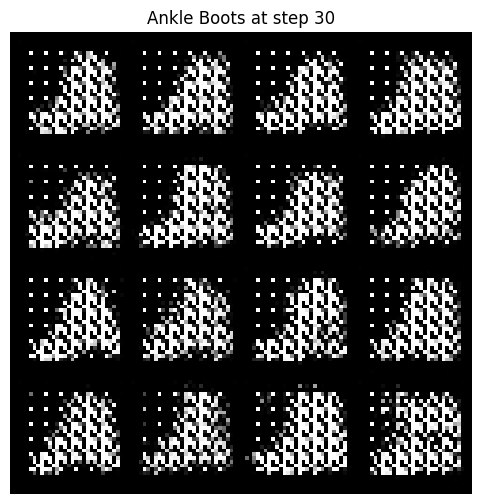

Fine-tune step 40, D Loss: 98.0162, G Loss: -1188.9695


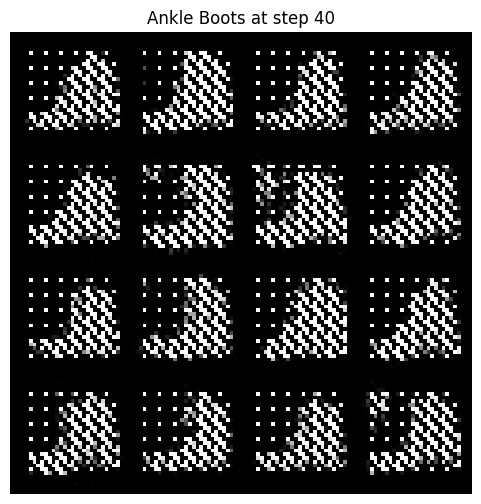

Fine-tune step 50, D Loss: 101.4933, G Loss: -1573.1559


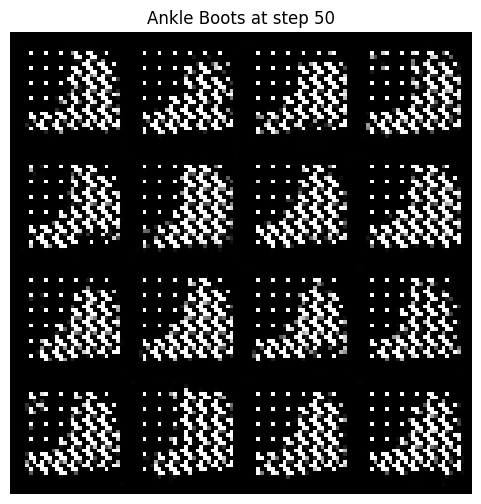

In [ ]:
# ✅ Install Dependencies
!pip install torch torchvision matplotlib tqdm higher --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random, higher

# -----------------------------
# Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1. Hyperparameters
# -----------------------------
latent_dim = 64
inner_lr = 0.005
meta_lr = 0.0005
inner_steps = 1
meta_epochs = 20
num_tasks = 8
k_shot = 8
q_query = 8
lambda_gp = 5
n_critic = 1

# -----------------------------
# 2. Dataset Preparation
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Meta-training: classes 0–8
meta_train_indices = [i for i, (_,y) in enumerate(dataset) if y in range(0,9)]
meta_train_data = Subset(dataset, meta_train_indices)

# Meta-testing: class 9 (ankle boot)
meta_test_indices = [i for i, (_,y) in enumerate(dataset) if y == 9]
meta_test_data = Subset(dataset, meta_test_indices)

# -----------------------------
# 3. CNN Generator
# -----------------------------
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        z = z.view(z.size(0), latent_dim, 1, 1)
        return self.net(z)

# -----------------------------
# 4. CNN Discriminator
# -----------------------------
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LayerNorm([128, 7, 7]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------
# 5. Initialize Models
# -----------------------------
gen = CNNGenerator(latent_dim).to(device)
disc = CNNDiscriminator().to(device)

# -----------------------------
# 6. Gradient Penalty Function
# -----------------------------
def gradient_penalty(disc, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1).to(device)
    interpolates = alpha * real + ((1 - alpha) * fake)
    interpolates.requires_grad_(True)
    d_interpolates = disc(interpolates)
    grad_outputs = torch.ones_like(d_interpolates).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# -----------------------------
# 7. Task Sampling
# -----------------------------
def sample_task(dataset, k_shot, q_query):
    class_id = random.choice(range(0,9))
    indices = [i for i, (_,y) in enumerate(dataset) if y == class_id]
    chosen = random.sample(indices, k_shot + q_query)
    support_idx, query_idx = chosen[:k_shot], chosen[k_shot:]
    support = torch.stack([dataset[i][0] for i in support_idx])
    query = torch.stack([dataset[i][0] for i in query_idx])
    return support.to(device), query.to(device)

# -----------------------------
# 8. Meta-Training Loop
# -----------------------------
meta_opt = optim.Adam(list(gen.parameters()) + list(disc.parameters()), lr=meta_lr, betas=(0.5, 0.9))

for epoch in range(meta_epochs):
    task_losses = []
    for task in range(num_tasks):
        support, query = sample_task(meta_train_data, k_shot, q_query)

        d_opt = optim.SGD(disc.parameters(), lr=inner_lr)
        g_opt = optim.SGD(gen.parameters(), lr=inner_lr)

        with higher.innerloop_ctx(disc, d_opt, copy_initial_weights=True, track_higher_grads=False) as (d_inner, d_opt_inner), \
             higher.innerloop_ctx(gen, g_opt, copy_initial_weights=True, track_higher_grads=False) as (g_inner, g_opt_inner):

            for _ in range(inner_steps):
                # Critic update
                for _ in range(n_critic):
                    z = torch.randn(k_shot, latent_dim).to(device)
                    fake = g_inner(z)
                    d_real = d_inner(support).mean()
                    d_fake = d_inner(fake.detach()).mean()
                    gp = gradient_penalty(d_inner, support, fake)
                    d_loss = -(d_real - d_fake) + lambda_gp * gp
                    d_opt_inner.step(d_loss)

                # Generator update
                z = torch.randn(k_shot, latent_dim).to(device)
                fake = g_inner(z)
                g_loss = -d_inner(fake).mean()
                g_opt_inner.step(g_loss)

            # Meta-loss on query
            zq = torch.randn(q_query, latent_dim).to(device)
            fake_q = g_inner(zq)
            d_real_q = d_inner(query).mean()
            d_fake_q = d_inner(fake_q.detach()).mean()
            gp_q = gradient_penalty(d_inner, query, fake_q)
            d_loss_q = -(d_real_q - d_fake_q) + lambda_gp * gp_q
            g_loss_q = -d_inner(fake_q).mean()

            meta_loss = d_loss_q + g_loss_q
            task_losses.append(meta_loss)

    meta_loss = torch.stack(task_losses).mean()
    meta_opt.zero_grad()
    meta_loss.backward()
    meta_opt.step()

    print(f"Epoch {epoch+1}/{meta_epochs}, Meta Loss: {meta_loss.item():.4f}")

# -----------------------------
# 9. Few-shot Fine-tuning on Ankle Boots
# -----------------------------
ft_indices = random.sample(range(len(meta_test_data)), 20)
ft_data = torch.stack([meta_test_data[i][0] for i in ft_indices]).to(device)

ft_opt = optim.Adam(list(gen.parameters()) + list(disc.parameters()), lr=inner_lr, betas=(0.5, 0.9))

for step in range(50):
    for _ in range(n_critic):
        z = torch.randn(20, latent_dim).to(device)
        fake = gen(z)
        d_real = disc(ft_data).mean()
        d_fake = disc(fake.detach()).mean()
        gp = gradient_penalty(disc, ft_data, fake)
        d_loss = -(d_real - d_fake) + lambda_gp * gp
        ft_opt.zero_grad()
        d_loss.backward()
        ft_opt.step()

    z = torch.randn(20, latent_dim).to(device)
    fake = gen(z)
    g_loss = -disc(fake).mean()
    ft_opt.zero_grad()
    g_loss.backward()
    ft_opt.step()

    if (step+1) % 10 == 0:
        print(f"Fine-tune step {step+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            samples = gen(z).cpu()
            grid = vutils.make_grid(samples, nrow=4, normalize=True)
            plt.figure(figsize=(6,6))
            plt.imshow(np.transpose(grid, (1,2,0)))
            plt.title(f"Ankle Boots at step {step+1}")
            plt.axis("off")
            plt.show()
